# Local version of the NoteBook available on dspillustrations.com

This notebook is an implementation of the Schmild and Cox synchronization algorithm for OFDM. The algorithm is described in the paper "Robust Synchronization Techniques for OFDM Systems" by Schmild and Cox. The algorithm is based on the correlation of the received signal with itself.

This notebook is based on the following references:
1. Schmild and Cox, "Robust Synchronization Techniques for OFDM Systems", IEEE Transactions on Communication, 1997.
2. https://dspillustrations.com/pages/posts/misc/schmidlcox-synchronization-for-ofdm.html

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
colors = {
    'lightblue': '#6b8fb4',
    'red': '#d9534f',
    'green': '#5cb85c',
    'yellow': '#f0ad4e',
    'indigo': '#563d7c',
    'blue': '#0275d8',
    'darkblue': '#00204e'
}

# Set the matplotlib color cycle to the colors above
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[colors['blue'], colors['red'], colors['green'], colors['yellow'], colors['indigo'], colors['lightblue'], colors['darkblue']])

Let $x(t)$ be the transmitted signal. The received signal $r(t)$ can be described as: $$r(t) = x(t - \tau) + n(t)$$ where $\tau$ is the time offset and $n(t)$ is AWGN. $\tau$ is unknown at the receiver and needs to be estimated.

Schmild and Cox propose a synchronization algorithm based on a specific frame structure. The frame begins with a special symbol called **preamble**, which consists of two repeated parts, prepended by a cycle prefix (CP). The following figure shows the frame structure used in this notebook.


```txt
+----+---------+---------+----+---------------+----+---------------+----+---------------+
| CP |    A    |    A    | CP |    payload    | CP |    payload    | CP |    payload    |
+----+---------+---------+----+---------------+----+---------------+----+---------------+
|<------ Preamble ------>|<----------------------- N OFDM Symbols --------------------->|
```

Each frame starts with a preamble, which consists of two identical parts $A$. The preamble is followed by the payload, which consists of $N$ OFDM symbols. Schmidl and Cox do not impose any restrictions on $A$, which can contains information if we want. The only requirement is that $A$ is repeated twice in the preamble.


## Modeling the received signal

Let's start by modeling the received signal. 

In [3]:
# Hold the OFDM parameters
class OFDM: pass
ofdm = OFDM()

ofdm.K = 1024                   # Number of OFDM subcarriers
ofdm.Kon = 600                  # Number of switched-on subcarriers
ofdm.CP = 128                   # Number of samples in the cyclic prefix
ofdm.ofdmSymbolsPerFrame = 5    # N, number of OFDM symbols in each frame
ofdm.L = ofdm.K // 2            # Parameter L, denotes the length of one repeated part of the preamble

In [4]:
def random_quam(ofdm):
    """ Generate a random QAM symbol for each subcarrier. """
    quam = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2)        # QAM symbols (normalized to unit power)
    return np.random.choice(quam, size=(ofdm.Kon), replace=True)

The following cells generate a random OFDM symbol and prepend it with the cyclic prefix.

In [5]:
def ofdm_modulate(ofdm, quam):
    """ Performs OFDM modulation and CP addition. """
    assert (len(quam) == ofdm.Kon)
    
    fd_data = np.zeros(ofdm.K, dtype=complex)
    off = (ofdm.K - ofdm.Kon) // 2                      # Offset to the center of the frequency
    fd_data[off:(off+len(quam))] = quam                 # Modulate in the center of the frequency
    fd_data = np.fft.ifftshift(fd_data)                 # Shift to the baseband
    symbols = np.fft.ifft(fd_data) * np.sqrt(ofdm.K)    # Perform the IFFT
    return np.hstack([symbols[-ofdm.CP:], symbols])     # Add the cyclic prefix   

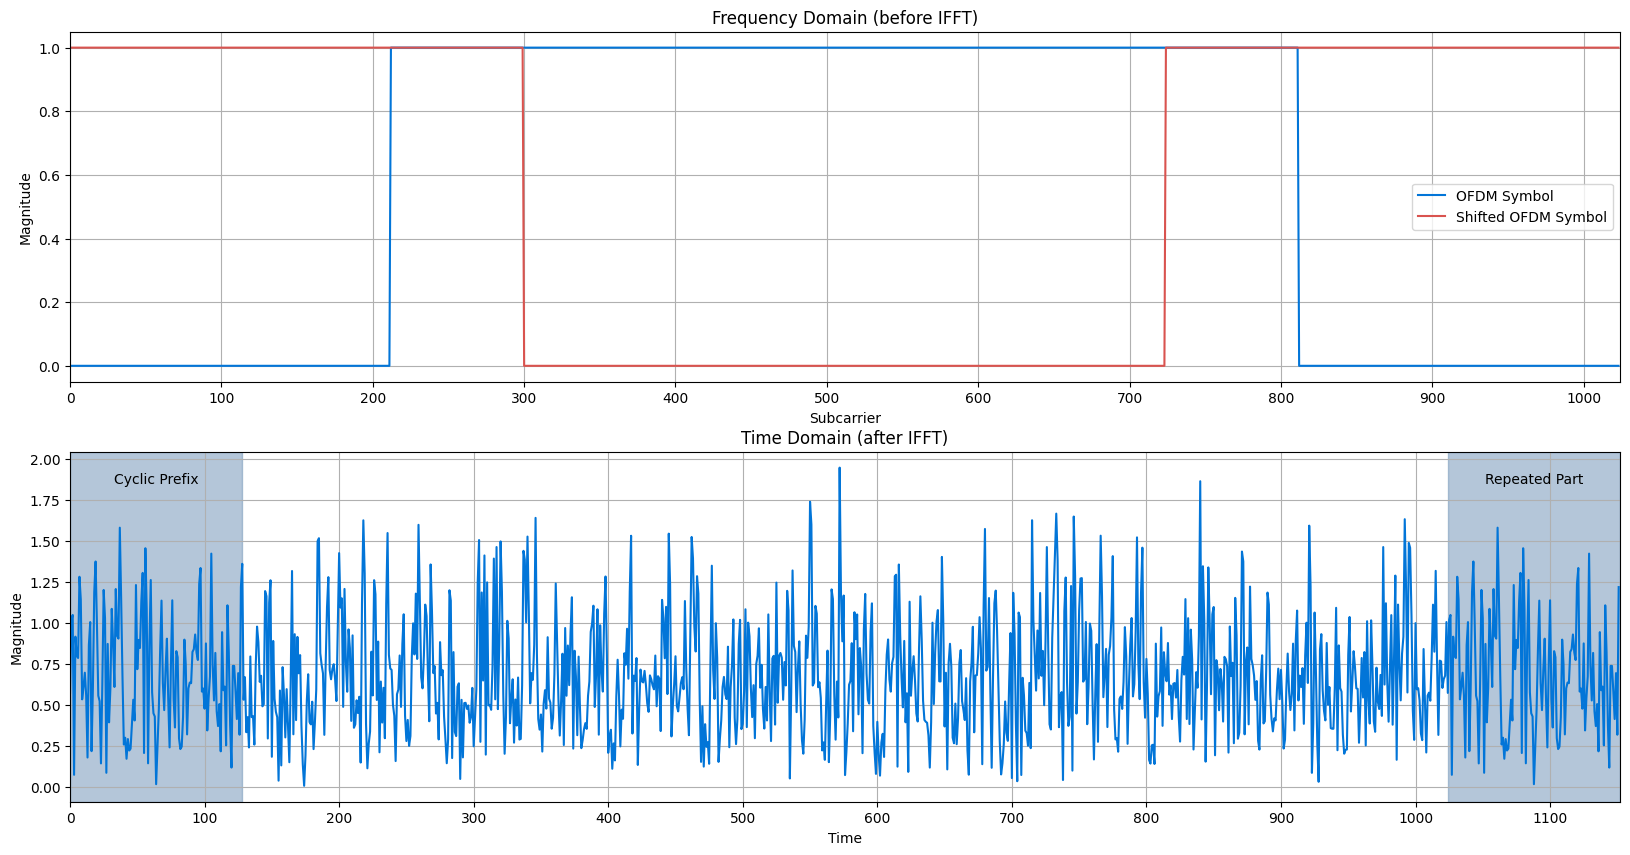

In [6]:
# Analyze the creatation of the OFDM symbols
fd_data = np.zeros(ofdm.K, dtype=complex)
off = (ofdm.K - ofdm.Kon) // 2
fd_data[off:(off+ofdm.Kon)] = random_quam(ofdm)
fd_data_shifted = np.fft.ifftshift(fd_data)
symbols = np.fft.ifft(fd_data_shifted) * np.sqrt(ofdm.K)
symbols_cp = np.hstack([symbols[-ofdm.CP:], symbols])

fig = plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.title('Frequency Domain (before IFFT)')
plt.plot(abs(fd_data), label='OFDM Symbol')
plt.plot(abs(fd_data_shifted), label='Shifted OFDM Symbol')
plt.legend()
plt.xlabel('Subcarrier')
plt.ylabel('Magnitude')
plt.xlim([0, ofdm.K])
plt.xticks(np.arange(0, ofdm.K, 100))
plt.grid(True)

plt.subplot(2, 1, 2)
plt.title('Time Domain (after IFFT)')
plt.plot(abs(symbols_cp))
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.xlim([0, ofdm.K + ofdm.CP])
plt.xticks(np.arange(0, ofdm.K + ofdm.CP, 100))
plt.text(ofdm.CP // 2, max(abs(symbols_cp) * 0.95), 'Cyclic Prefix', horizontalalignment='center')
plt.axvspan(0, ofdm.CP, color=colors['lightblue'], alpha=0.5)
plt.text(ofdm.K + ofdm.CP // 2, max(abs(symbols_cp) * 0.95), 'Repeated Part', horizontalalignment='center')
plt.axvspan(ofdm.K, ofdm.K + ofdm.CP, color=colors['lightblue'], alpha=0.5)
plt.grid(True)

Let's generate an example of a preamble. To generate a periodic signal, we exploit the fact that the DFT (Discrete Fourier Transform) of $P$-periodic sequence (a sequence consisting of $P$ repetitions of the same sequence), is non-zero only every $P$-th sample. Hence, if we create a frequency domain signal with every other sample being zero, and then take the inverse DFT, we will get a 2-periodic time-domain signal.

The symbol $A$ of the above figure is 2-periodic in time domain.

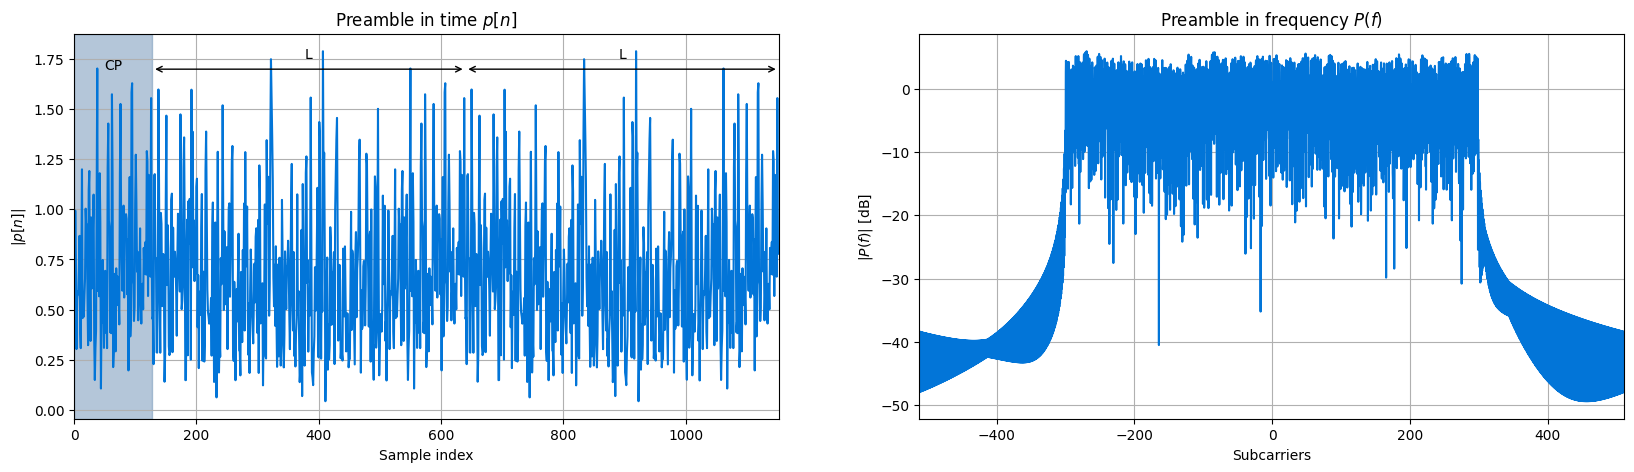

In [7]:
quam_preamble = np.sqrt(2) * random_quam(ofdm)
quam_preamble[::2] = 0                          # Delete every second data to make the preamble 2-periodic
preamble = ofdm_modulate(ofdm, quam_preamble)

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title('Preamble in time $p[n]$')
plt.plot(np.abs(preamble))
plt.xlabel('Sample index')
plt.ylabel('$|p[n]|$')
plt.xlim([0, ofdm.K + ofdm.CP])
plt.text(ofdm.CP // 2, max(abs(preamble) * 0.95), 'CP', horizontalalignment='center')
plt.axvspan(0, ofdm.CP, color=colors['lightblue'], alpha=0.5)
for i in range(ofdm.CP, ofdm.K, ofdm.L):
    plt.annotate('', xy=(i, max(abs(preamble) * 0.95)), xytext=(i+ofdm.L, max(abs(preamble) * 0.95)), arrowprops=dict(arrowstyle='<->'))
    plt.text(i + ofdm.L // 2, max(abs(preamble) * 0.98), 'L', horizontalalignment='center')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Preamble in frequency $P(f)$')
f = np.linspace(-ofdm.K/2, ofdm.K/2-1, 4*len(preamble), endpoint=False)
plt.plot(f, 20 * np.log10(np.abs(np.fft.fftshift(np.fft.fft(preamble, 4*len(preamble)) / np.sqrt(len(preamble))))))
plt.xlabel('Subcarriers')
plt.ylabel('$|P(f)|$ [dB]')
plt.xlim([-ofdm.K/2, ofdm.K/2-1])
plt.grid(True)

We now generate a whole frame as described above.

In [8]:
def createFrame(ofdm, quam_preamble=None):
    """ Create a frame with a preamble and random data. """
    if quam_preamble is None:
        quam_preamble = np.sqrt(2) * random_quam(ofdm)
        quam_preamble[::2] = 0
    preamble = ofdm_modulate(ofdm, quam_preamble)
    
    payload = np.hstack([ofdm_modulate(ofdm, random_quam(ofdm)) for _ in range(ofdm.ofdmSymbolsPerFrame)])
    return np.hstack([preamble, payload])

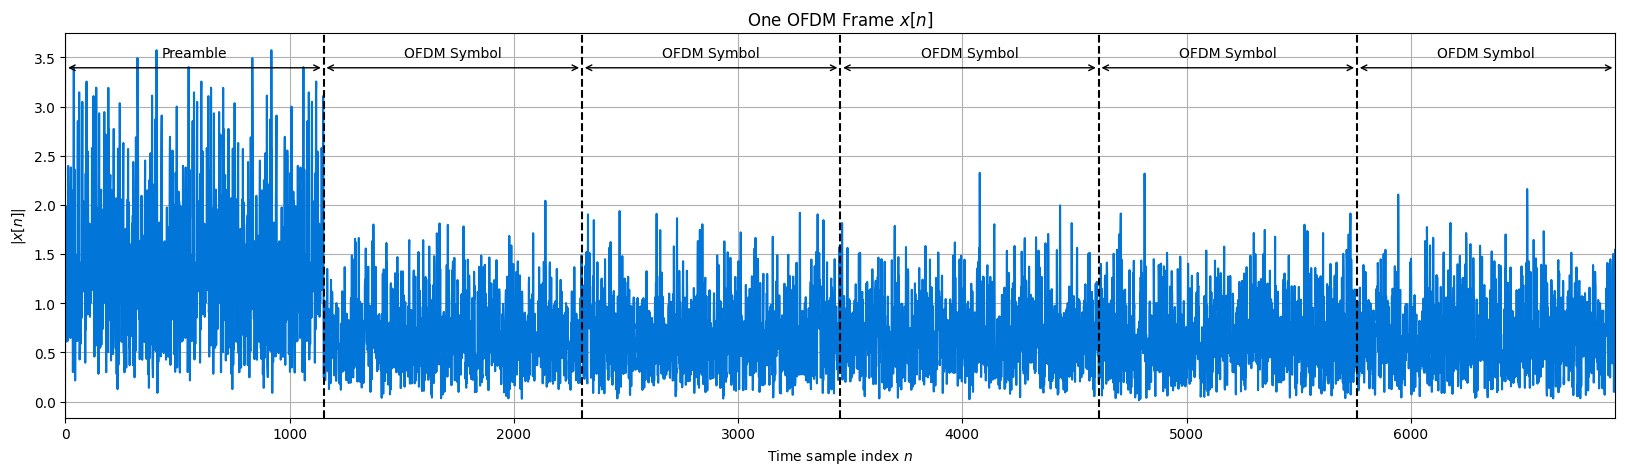

In [9]:
frame = createFrame(ofdm, quam_preamble=quam_preamble * 2)  # Double the preamble power to make it more visible

plt.figure(figsize=(20, 5))
plt.title('One OFDM Frame $x[n]$')
plt.plot(np.abs(frame))
plt.xlabel('Time sample index $n$')
plt.ylabel('$|x[n]|$')
plt.grid(True)
plt.xlim([0, len(frame)])

plt.text(len(preamble) / 2, max(np.abs(frame)) * 0.98, 'Preamble', ha='center')
for i in range(0, len(frame), len(preamble)):
    if i + len(preamble) < len(frame):
        plt.text(i + len(preamble) + len(preamble) / 2, max(np.abs(frame)) * 0.98, 'OFDM Symbol', ha='center')
    plt.annotate('', xy=(i, max(np.abs(frame) * 0.95)), xytext=(i + len(preamble), max(np.abs(frame) * 0.95),), arrowprops=dict(arrowstyle='<->'))
    plt.axvline(x=i, color='black', linestyle='--')



Now we add model the channel 

In [10]:
def addCFO(signal, cfo):
    """ Add carrier frequency offset """
    return signal * np.exp(2j * np.pi * cfo * np.arange(len(signal)))

def addSTO(signal, sto):
    """ Add sample timing offset """
    return np.hstack([np.zeros(sto), signal])

def addNoise(signal, sigma2):
    """ Add AWGN noise """
    noise = np.sqrt(sigma2 / 2) * (np.random.randn(len(signal)) + 1j * np.random.randn(len(signal)))
    return signal + noise

def addChannel(signal, h):
    """ Add multipath impulse response """
    return sp.signal.lfilter(h, (1, ), signal)

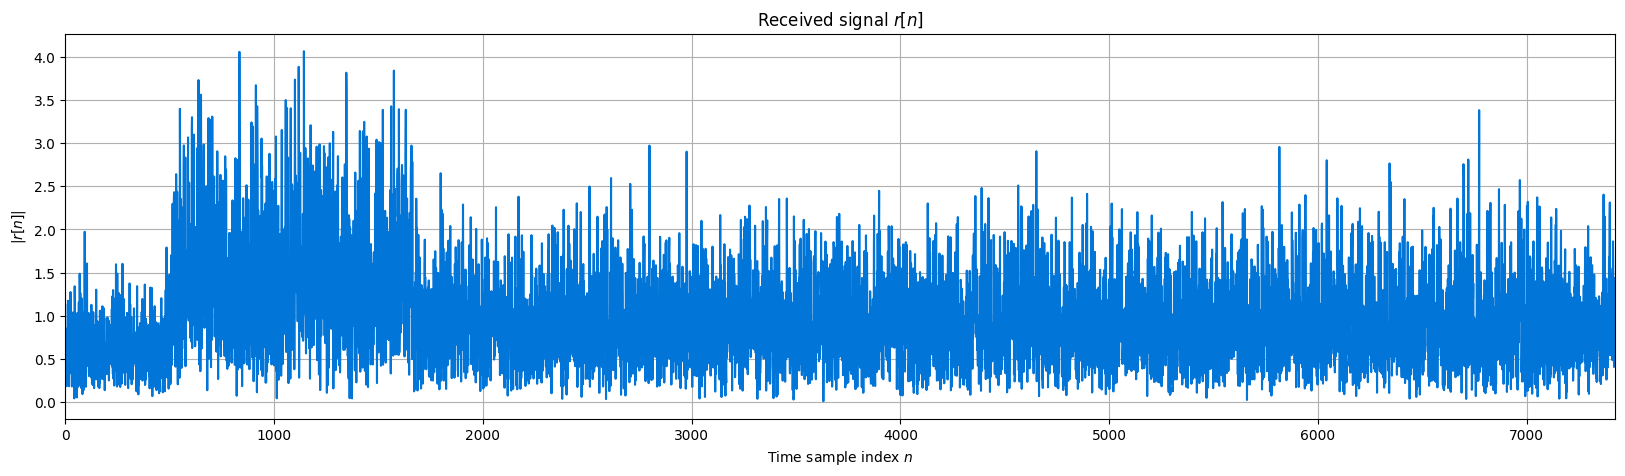

In [11]:
x = createFrame(ofdm, quam_preamble=quam_preamble * 2)
sto = ofdm.K // 2
r = addNoise(addSTO(x, sto), 0.5)

plt.figure(figsize=(20, 5))
plt.title('Received signal $r[n]$')
plt.plot(np.abs(r))
plt.xlabel('Time sample index $n$')
plt.ylabel('$|r[n]|$')
plt.xlim([0, len(r)])
plt.grid(True)


## Implementing the Schmild and Cox algorithm for OFDM synchronization

The Schmild and Cox algorithm is based on a metric which is calculated from the received signal. When the metric goes beyond a certain threshold, the receiver detects the preamble and estimates the time offset.

### Calculating $P(d)$

In the original, the authors propose a metric called $P(d)$, which is calculated from the received signal. 
The metric is defined as: $$P(d) = \sum_{m=0}^{L-1} r[d + m]* r[d + m + L]$$ where $r(n)$ is the received signal and $L$ is the length of one-half of the first symbol in the preamble. 

In [12]:
# Calculation of P(d) as defined by the above formula (method 1)
d_set = np.arange(0, sto + 2 * ofdm.K)
P1 = np.zeros(len(d_set), dtype=complex)
for i, d in enumerate(d_set):
    P1[i] = sum(r[d+m].conj() * r[d+m+ofdm.L] for m in range(0, ofdm.L))

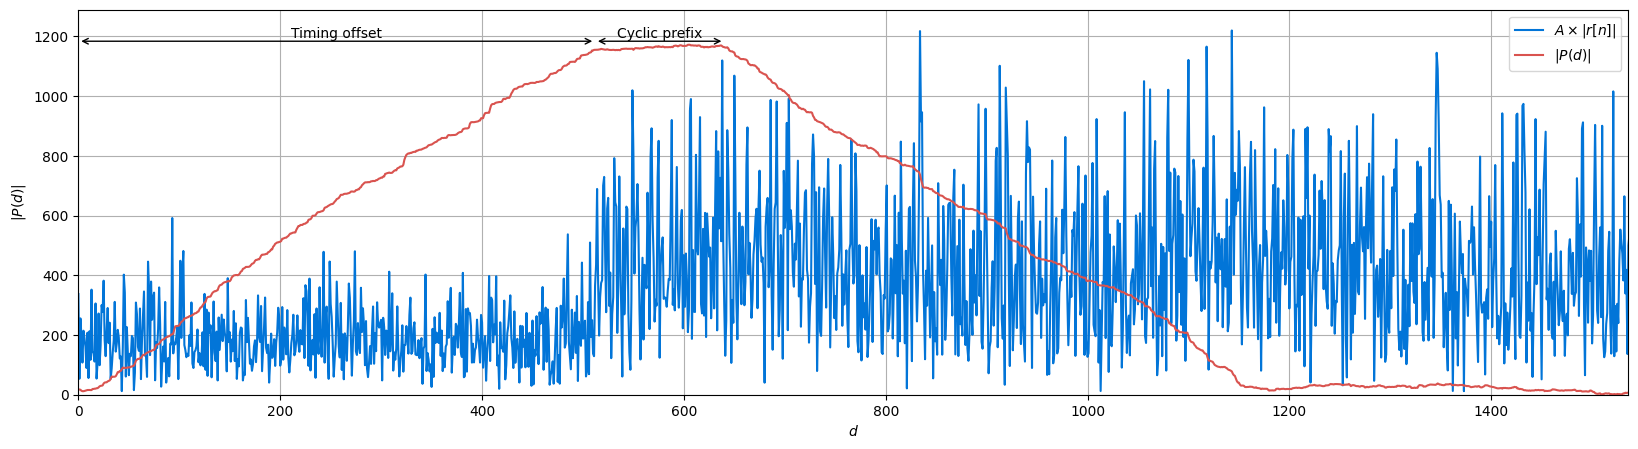

In [13]:
plt.figure(figsize=(20, 5))
plt.plot(abs(r) * 300, label='$A \\times |r[n]|$')
plt.plot(d_set, np.abs(P1), label='$|P(d)|$')
plt.legend()
plt.xlabel('$d$')
plt.ylabel('$|P(d)|$')
plt.xlim([0, sto + ofdm.K])
plt.ylim([0, max(abs(P1)) * 1.1])
plt.text(sto // 2, max(abs(P1)) * 1.02, 'Timing offset', horizontalalignment='center')
plt.annotate('', xy=(0, max(abs(P1)) * 1.01), xytext=(sto, max(abs(P1)) * 1.01,), arrowprops=dict(arrowstyle='<->'))
plt.text(sto + ofdm.CP // 2, max(abs(P1)) * 1.02, 'Cyclic prefix', horizontalalignment='center')
plt.annotate('', xy=(sto, max(abs(P1)) * 1.01), xytext=(sto + ofdm.CP, max(abs(P1)) * 1.01,), arrowprops=dict(arrowstyle='<->'))
plt.grid(True)

We observe that the metric $P(d)$ reaches a plateau starting at the timing offset $\tau$ and ending at $\tau + \text{CP}$: the plateau has a width equal to the cyclic prefix length.

Schmild and Cox propose an alternative method to calculate $P(d)$, which is easier to implement: $$P(d + 1) = P(d) + r[d + L]^* r[d + 2L] - r[d]^* r[d + L]$$ However, this method requires a starting value for $P(0)$.

Maximum difference between the two methods: 1.3647045671839256e-12 occurs at d = 679


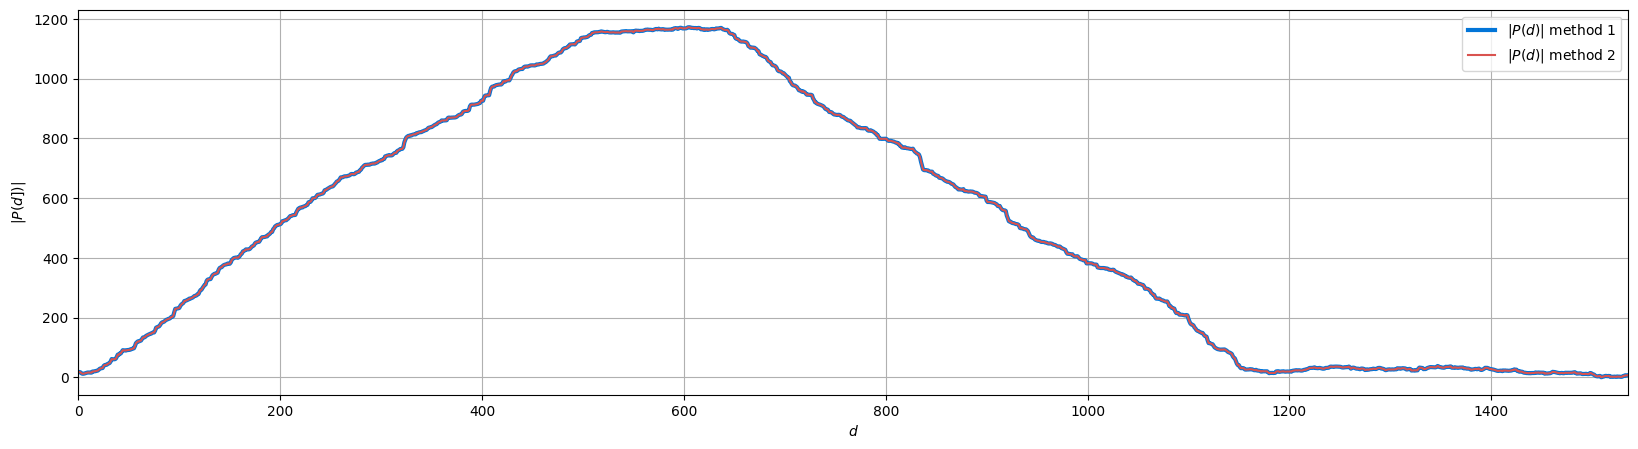

In [14]:
# Method 2 to calculate P(d)
P1_0 = sum(r[m].conj() * r[m+ofdm.L] for m in range(0, ofdm.L)) # Initialize P[0] with the default method
P2 = np.zeros(len(d_set), dtype=complex)
P2[0] = P1_0
for d in d_set[:-1]:
    P2[d+1] = P2[d] + r[d+ofdm.L].conj() * r[d+2*ofdm.L] - r[d].conj() * r[d+ofdm.L]

plt.figure(figsize=(20, 5))
plt.plot(d_set, np.abs(P1), label='$|P(d)|$ method 1', lw=3)
plt.plot(d_set, np.abs(P2), label='$|P(d)|$ method 2')
plt.legend()
plt.xlabel('$d$')
plt.ylabel('$|P(d])|$')
plt.xlim([0, sto + ofdm.K])
plt.grid(True)

print(f'Maximum difference between the two methods: {np.max(np.abs(P1 - P2))} occurs at d = {np.argmax(np.abs(P1 - P2))}')

Both equations are equivalent. Let's now see what is happening if we initialize $P(d)$ with $P(0) = 0$.

Maximum difference between the two methods: 18.048991778976596 occurs at d = 697


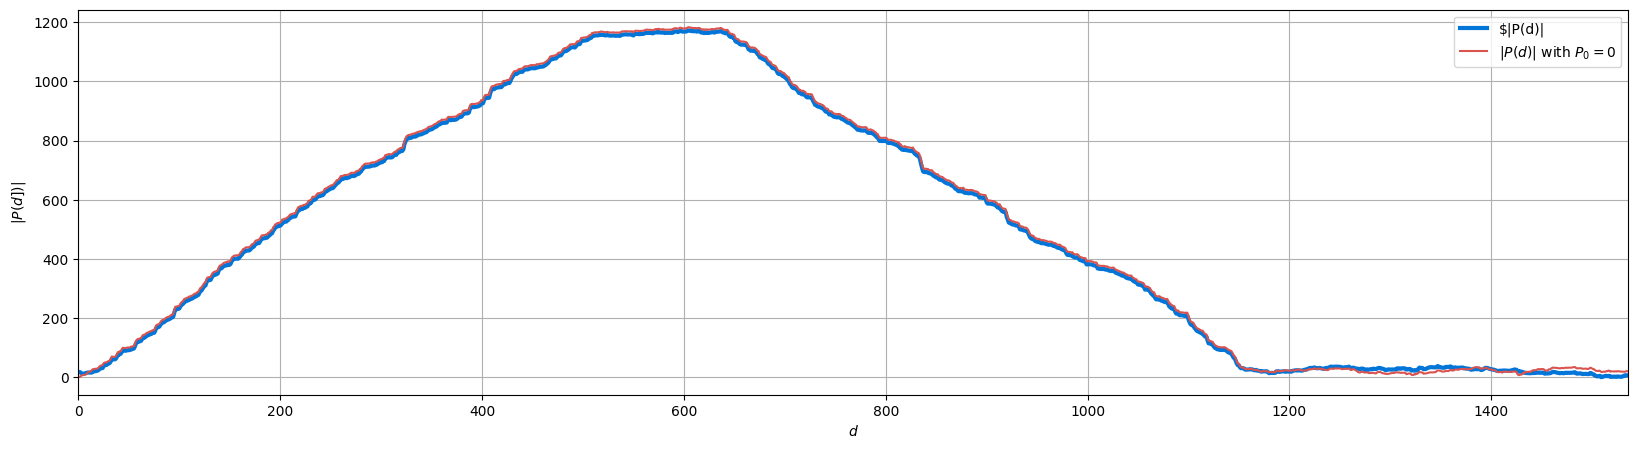

In [15]:
P2_0 = np.zeros(len(d_set), dtype=complex)
P2_0[0] = 0
for d in d_set[:-1]:
    P2_0[d+1] = P2_0[d] + r[d+ofdm.L].conj() * r[d+2*ofdm.L] - r[d].conj() * r[d+ofdm.L]

plt.figure(figsize=(20, 5))
plt.plot(d_set, np.abs(P2), label='$|P(d)|', lw=3)
plt.plot(d_set, np.abs(P2_0), label='$|P(d)|$ with $P_0 = 0$')
plt.legend()
plt.xlabel('$d$')
plt.ylabel('$|P(d])|$')
plt.xlim([0, sto + ofdm.K])
plt.grid(True)

print(f'Maximum difference between the two methods: {np.max(np.abs(P2 - P2_0))} occurs at d = {np.argmax(np.abs(P2 - P2_0))}')

As we see, the two curves marginally differ, and the two shapes remain the same.

However, we see that the above metric is not causal, as it requires the knowledge of the future samples. To make it causal, we introduce the signal $v[d]$ as: $$v[d] = r[d + L]^* r[d + 2L]$$ With this definition, $P(d)$ can be written as $$P(d + 1) = P(d) + v[d] - v[d - L]$$ which seemingly becomes a linear IIR filtering operation of the signal $v[d]$. 

To make it causal, we introduce a delay of $2L$ samples to $r[d]$ to yield $\bar{r}[d] = r[d - 2L]$. The causal version of $\bar{P}[d]$ is then: $$\bar{P}[d + 1] = \bar{P}[d] + \bar{v}[d] - \bar{v}[d - L]$$ where $\bar{v}[d] = \bar{r}[d + L]^* \bar{r}[d + 2L] = r[d - L]^* r[d]$.

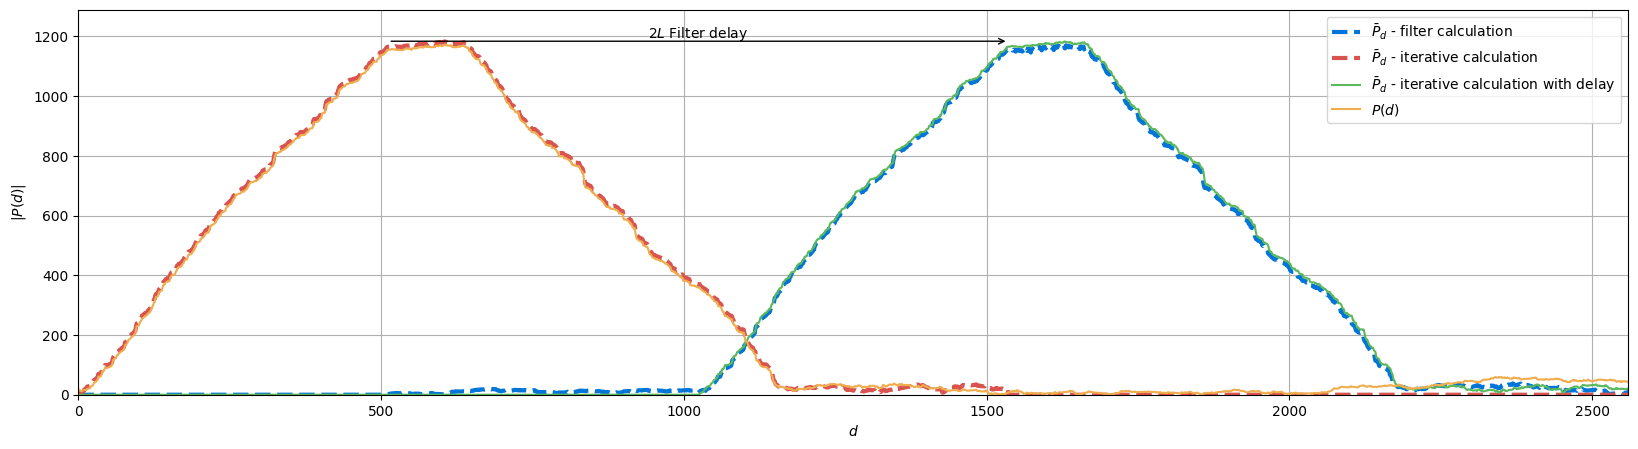

In [16]:
# Calculate P_bar(d) using iterative method (causal calculation by storing the last 2L values)
P_bar = np.zeros(len(d_set), dtype=complex)
P_bar_delay = np.zeros(len(d_set), dtype=complex)
for d in d_set[2 * ofdm.L:-1]:
    P_bar[d - 2 * ofdm.L + 1] = P_bar[d - 2 * ofdm.L] + r[d - ofdm.L].conj() * r[d] - r[d - 2 * ofdm.L].conj() * r[d - ofdm.L]
    P_bar_delay[d + 1] = P_bar_delay[d] + r[d - ofdm.L].conj() * r[d] - r[d - 2 * ofdm.L].conj() * r[d - ofdm.L]

# Calculate P_bar(d) using the filter method
b_P = np.zeros(ofdm.L, dtype=complex); b_P[0] = 1; b_P[-1] = -1
a_P = (1, -1)
v_bar_filter = np.hstack([np.zeros(ofdm.L), r[ofdm.L:].conj() * r[:-ofdm.L]])
P_bar_filter = sp.signal.lfilter(b_P, a_P, v_bar_filter)


plt.figure(figsize=(20, 5))
plt.plot(abs(P_bar_filter), label='$\\bar{P}_d$ - filter calculation', lw=3, linestyle='--')
plt.plot(abs(P_bar), label='$\\bar{P}_d$ - iterative calculation', lw=3, linestyle='--')
plt.plot(abs(P_bar_delay), label='$\\bar{P}_d$ - iterative calculation with delay')
plt.plot(abs(P1), label='$P(d)$')
plt.legend()
plt.xlabel('$d$')
plt.ylabel('$|P(d)|$')
plt.xlim([0, sto + 4 * ofdm.L])
plt.ylim(0, max(abs(P1)) * 1.1)
plt.text(sto + (2 * ofdm.L // 2), max(abs(P1)) * 1.02, '$2L$ Filter delay', horizontalalignment='center')
plt.annotate('', xy=(sto, max(abs(P1)) * 1.01), xytext=(sto + 2 * ofdm.L, max(abs(P1)) * 1.01,), arrowprops=dict(arrowstyle='<-'))
plt.grid(True)

We see that the filter has a delay of $2L$ samples, compare to the non-causal version. To overcome non-causality, 3 methods are proposed:
1. Use the low-pass filtered version of the metric $P(d)$: **$\bar{P}(d)$ - filter calculation**
2. Store the last $2L$ samples of the received signal and calculate the metric $P(d)$ at time $d + 2L$: **$\bar{P}(d)$ - iterative calculation**
3. Store the last $2L$ samples of the received signal and calculate the metric $P(d)$ at time $d$, which introduce the delay of $2L$ samples: **$\bar{P}(d)$ - iterative calculation with delay**

For the linear IIR filter, we can look at the impulse response of the filter. The following cell calculates the response to $v[n] = \delta[n - 500]$

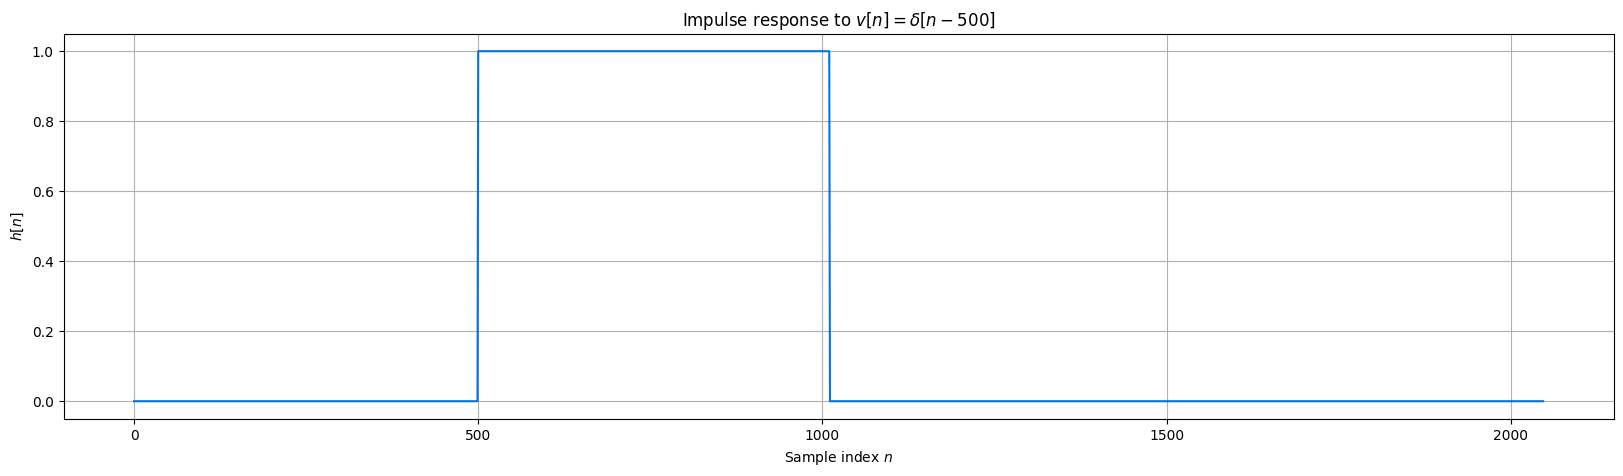

In [17]:
b = np.zeros(ofdm.L)
b[0] = 1
b[ofdm.L-1] = -1
a = (1, -1)
impulse = np.zeros(4 * ofdm.L)
impulse[500] = 1

plt.figure(figsize=(20, 5))
plt.title('Impulse response to $v[n] = \\delta[n-500]$')
plt.plot(np.arange(len(impulse)), sp.signal.lfilter(b, a, impulse))
plt.xlabel('Sample index $n$')
plt.ylabel('$h[n]$')
plt.grid(True)

## Calculating $R(d)$

In addition to the metric $P(d)$, Schmild and Cox propose another metric called $R(d)$, which is the received energy, given by: $$R(d) = \sum_{m=0}^{L-1} |r[d + m + L]|^2$$
In a similar way, we can calculate $R(d)$ as $$R(d + 1) = R(d) + |r[d + 2L]|^2 - |r[d + L]|^2$$ and derive the causal version of $R(d)$ as $$\bar{R}(d + 1) = \bar{R}(d) + |\bar{r}[d]|^2 - |\bar{r}[d - L]|^2$$

In [18]:
# Calculation based on the iterative method
R1 = np.zeros(len(d_set))
for i, d in enumerate(d_set):
    R1[i] = sum(abs(r[d+m+ofdm.L])**2 for m in range(ofdm.L))

# Calculation based on non-causal recusrive expression
R2 = np.zeros(len(d_set))
R2[0] = R1[0]
for d in d_set[:-1]:
    R2[d+1] = R2[d] + abs(r[d+2*ofdm.L])**2 - abs(r[d+ofdm.L])**2
    
# Calculation based on IIR filter expression
b_R = np.zeros(ofdm.L)
b_R[0] = 1
b_R[-1] = -1
a_R = (1, -1)
R_bar = sp.signal.lfilter(b_R, a_R, abs(r)**2)

# Calculation based on the iterative method with delay
R2_delay = np.zeros(len(d_set))
for d in d_set[ofdm.L:-1]:
    R2_delay[d+1] = R2_delay[d] + abs(r[d])**2 - abs(r[d-ofdm.L])**2

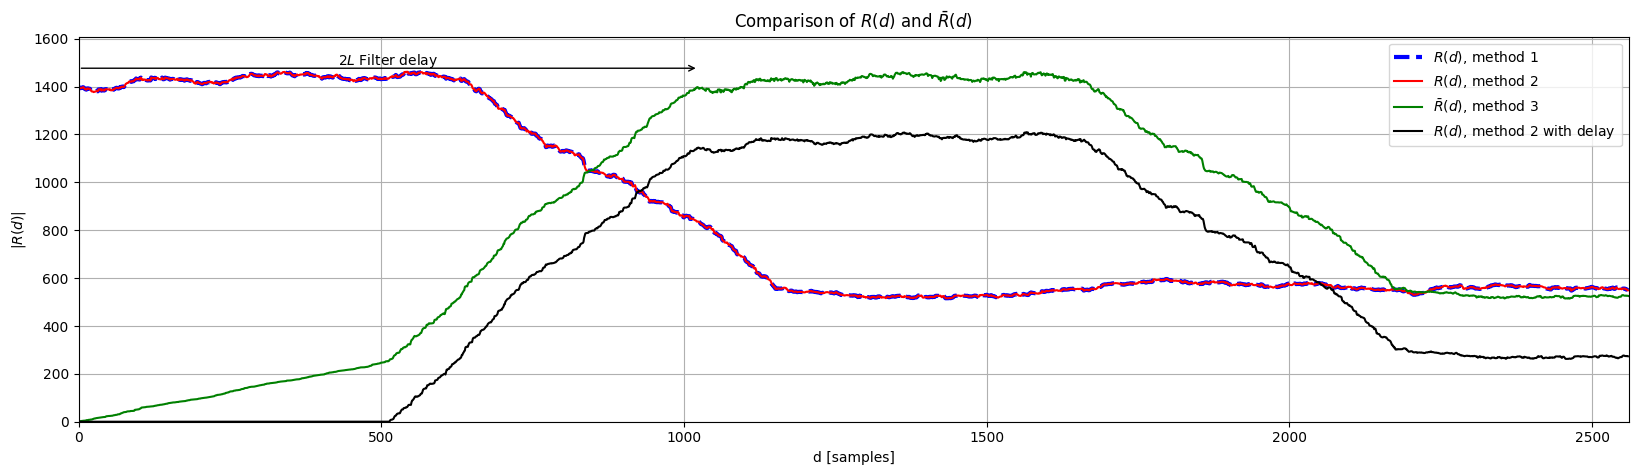

In [19]:
plt.figure(figsize=(20, 5))
plt.title('Comparison of $R(d)$ and $\\bar{R}(d)$')
plt.plot(abs(R1), 'b--', lw=3, label='$R(d)$, method 1')
plt.plot(abs(R2), 'r', label='$R(d)$, method 2')
plt.plot(abs(R_bar), 'g', label='$\\bar{R}(d)$, method 3')
plt.plot(abs(R2_delay), 'k', label='$R(d)$, method 2 with delay')
plt.legend()
plt.xlabel('d [samples]')
plt.ylabel('$|R(d)|$')
plt.xlim([0, len(d_set)])
plt.ylim([0, max(abs(R1)) * 1.1])
plt.text((2 * ofdm.L) // 2, max(abs(R1)) * 1.02, '$2L$ Filter delay', horizontalalignment='center')
plt.annotate('', xy=(0, max(abs(R1)) * 1.01), xytext=(2 * ofdm.L, max(abs(R1)) * 1.01,), arrowprops=dict(arrowstyle='<-'))
plt.grid(True)

## Calculating the final metric $M(d)$

The final metric $M(d)$ is calculated as: $$M(d) = \frac{|P(d)|^2}{R(d)^2}$$

/home/quentin/Documents/Cours/linfo2990/TFE25-462/env/lib/python3.12/site-packages/matplotlib/transforms.py:2872: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
/home/quentin/Documents/Cours/linfo2990/TFE25-462/env/lib/python3.12/site-packages/matplotlib/text.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))
/home/quentin/Documents/Cours/linfo2990/TFE25-462/env/lib/python3.12/site-packages/matplotlib/text.py:1467: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(y))
/home/quentin/Documents/Cours/linfo2990/TFE25-462/env/lib/python3.12/site-packages/matplotlib/text.py:898: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))


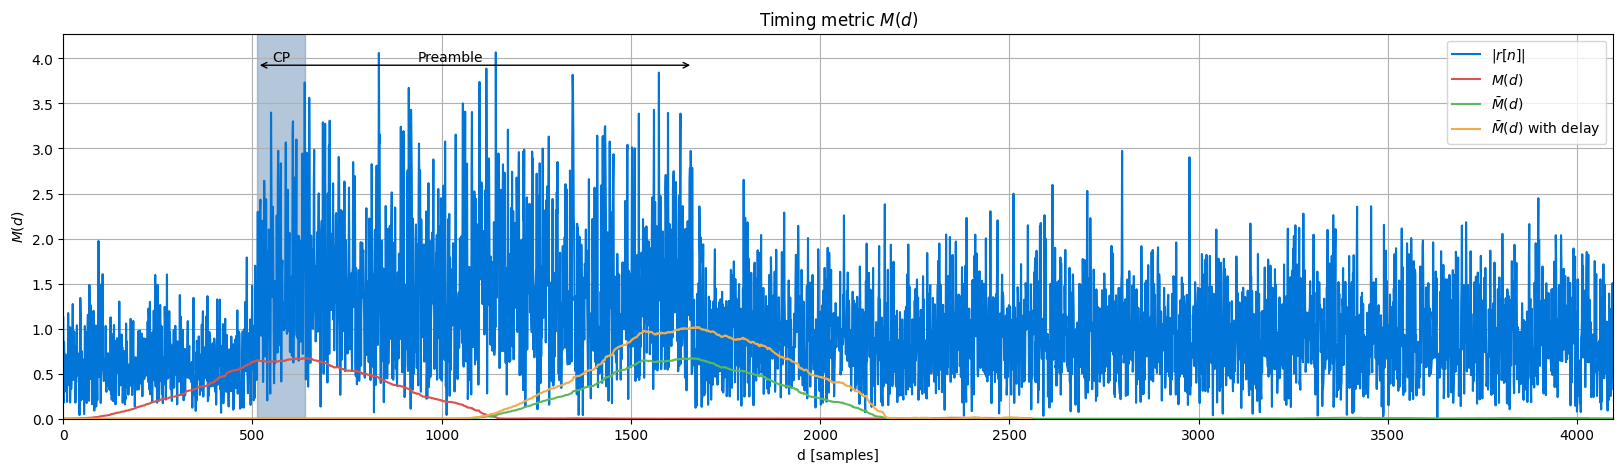

In [20]:
M = abs(P1) ** 2 / R1 ** 2
M_bar = abs(P_bar_filter) ** 2 / R_bar ** 2
M_bar_delay = np.divide(abs(P_bar_delay) ** 2, R2_delay ** 2, out=np.zeros_like(abs(P_bar_delay) ** 2), where=R2_delay != 0)

plt.figure(figsize=(20, 5))
plt.title('Timing metric $M(d)$')
plt.plot(abs(r), label='$|r[n]|$')
plt.plot(M, label='$M(d)$')
plt.plot(M_bar, label='$\\bar{M}(d)$')
plt.plot(M_bar_delay, label='$\\bar{M}(d)$ with delay')
plt.legend()
plt.xlabel('d [samples]')
plt.ylabel('$M(d)$')
plt.xlim([0, 4*ofdm.K])
plt.ylim([0, max(r) * 1.1])
plt.text(sto + ofdm.CP // 2, max(r) * 1.02, 'CP', horizontalalignment='center')
plt.axvspan(sto, sto + ofdm.CP, color=colors['lightblue'], alpha=0.5)
plt.text(sto + (2 * ofdm.L) // 2, max(r) * 1.02, 'Preamble', horizontalalignment='center')
plt.annotate('', xy=(sto, max(r) * 1.01), xytext=(sto + 2 * ofdm.L + ofdm.CP, max(r) * 1.01), arrowprops=dict(arrowstyle='<->'))
plt.grid(True)

As we can see, the original metric $M(d)$ reaches the maximum when the preamble starts. However, it is non-causal. To make it causal, we introduce the metric $\bar{M}(d)$ that has a delay of $2L$ samples.

In [21]:
def calcP_R_M(rx_signal, L):
    rx1 = rx_signal[:-L]
    rx2 = rx_signal[L:]
    mult = rx1.conj() * rx2
    square = abs(rx1 ** 2)
    
    zi = np.zeros(L-1)
    
    a_P = (1, -1)
    b_P = np.zeros(L)
    b_P[0] = 1
    b_P[-1] = -1
    P = sp.signal.lfilter(b_P, a_P, mult) / L
    R = sp.signal.lfilter(b_P, a_P, square) / L
    
    Pr = P[L:]
    Rr = R[L:]
    M = abs(Pr / Rr) ** 2
    return Pr, Rr, M    # Throw away the first L samples, as they are not correct due to filter causality

## Evaluation of the metric magnitude

In [22]:
from collections import defaultdict

M_dopt = defaultdict(list)
M_doutside = defaultdict(list)
SNRs = np.linspace(-10, 30, 21)
for SNR in SNRs:
    for i in range(100):
        tx_signal = createFrame(ofdm, quam_preamble=None)
        sigma_s2 = np.mean(abs(tx_signal ** 2))
        sigma_n2 = sigma_s2 * 10 ** (-SNR / 10.)
        sto = 1000
        cfo = 0.05 / ofdm.K
        rx_signal = addNoise(addCFO(addSTO(tx_signal, sto), cfo), sigma_n2)
        P, R, M = calcP_R_M(rx_signal, ofdm.L)
        M_dopt[SNR].append(M[sto])
        M_doutside[SNR].append(M[sto + ofdm.K])

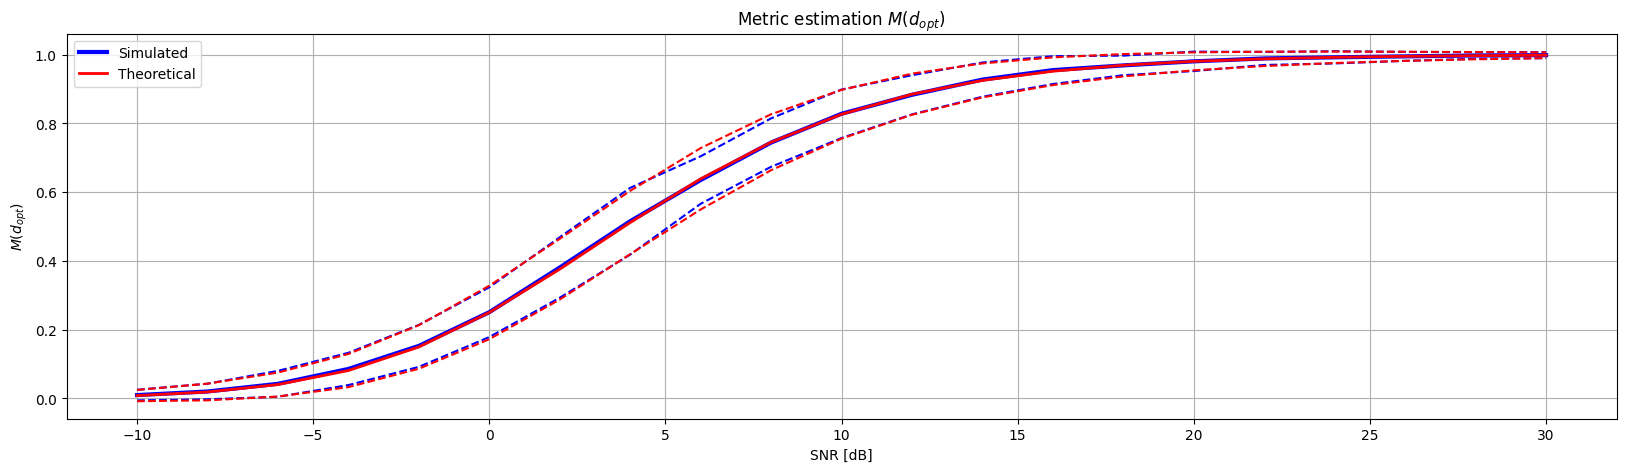

In [23]:
def calc_MeanSrd(SNRs, measurment):
    mean = np.array([np.mean(measurment[SNR]) for SNR in SNRs])
    std = np.array([np.std(measurment[SNR]) for SNR in SNRs])
    return mean, std
mean_opt, std_opt = calc_MeanSrd(SNRs, M_dopt)

plt.figure(figsize=(20, 5))
plt.title('Metric estimation $M(d_{opt})$')

# Plot the measured curves
plt.plot(SNRs, mean_opt, label='Simulated', color='blue', lw=3)
plt.plot(SNRs, mean_opt + 3*std_opt, 'b--')
plt.plot(SNRs, mean_opt - 3*std_opt, 'b--')

# Plot the theoretical curves
rho = 10**(-SNRs / 10)
mu = 1 / (1 + rho) ** 2
std = np.sqrt(2 * ((1 + mu) * rho + (1 + 2 * mu) * rho**2) / (ofdm.L * (1 + rho)**4))
plt.plot(SNRs, mu, label='Theoretical', color='r', lw=2)
plt.plot(SNRs, mu + 3*std, 'r--')
plt.plot(SNRs, mu - 3*std, 'r--')

plt.legend()
plt.xlabel('SNR [dB]')
plt.ylabel('$M(d_{opt})$')
plt.grid(True)

## Using $M(d)$ for synchronization

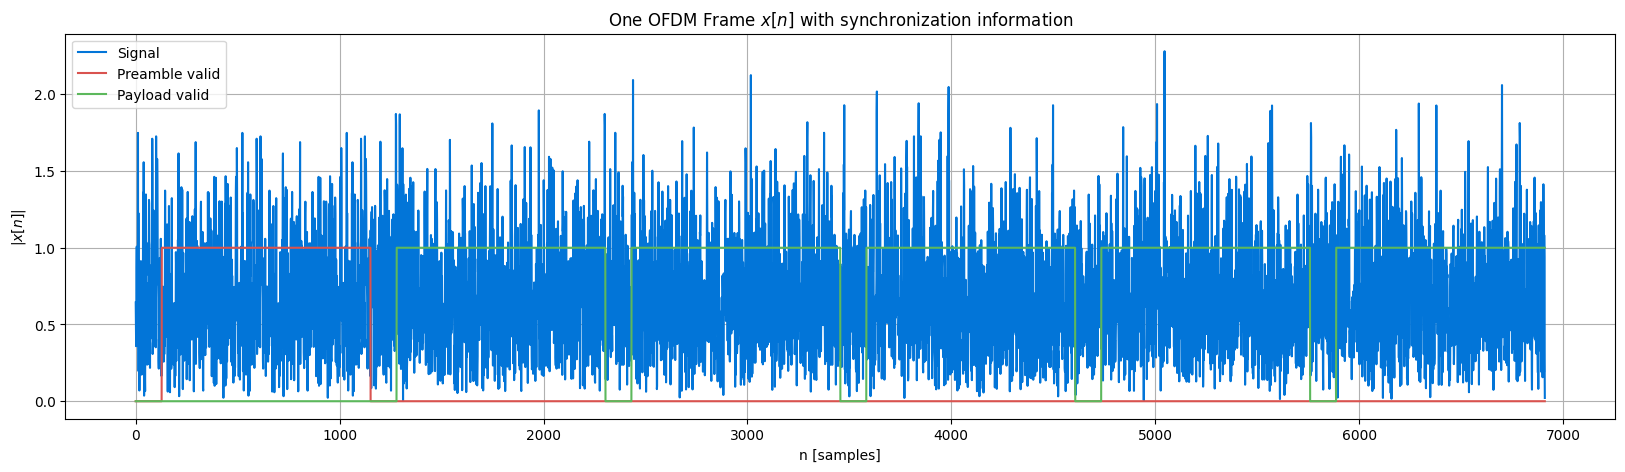

In [24]:
def createFrame_withSyncInfo(ofdm):
    quam_preamble = np.sqrt(2) * random_quam(ofdm)
    quam_preamble[::2] = 0
    preamble = ofdm_modulate(ofdm, quam_preamble)
    
    payload = np.hstack([ofdm_modulate(ofdm, random_quam(ofdm)) for _ in range(ofdm.ofdmSymbolsPerFrame)])
    
    frame = np.hstack([preamble, payload])
    preamble_valid = np.zeros(len(frame))
    payload_valid = np.zeros(len(frame))
    preamble_valid[ofdm.CP:ofdm.CP+ofdm.K] = 1
    for f in range(ofdm.ofdmSymbolsPerFrame):
        payload_valid[(ofdm.CP + ofdm.K) * (f+1) + ofdm.CP + np.arange(ofdm.K)] = 1
        
    return frame, preamble_valid, payload_valid

frame, preamble_valid, payload_valid = createFrame_withSyncInfo(ofdm)

plt.figure(figsize=(20, 5))
plt.title('One OFDM Frame $x[n]$ with synchronization information')
plt.plot(np.abs(frame), label='Signal')
plt.plot(preamble_valid, label='Preamble valid')
plt.plot(payload_valid, label='Payload valid')
plt.xlabel('n [samples]')
plt.ylabel('$|x[n]|$')
plt.legend()
plt.grid(True)

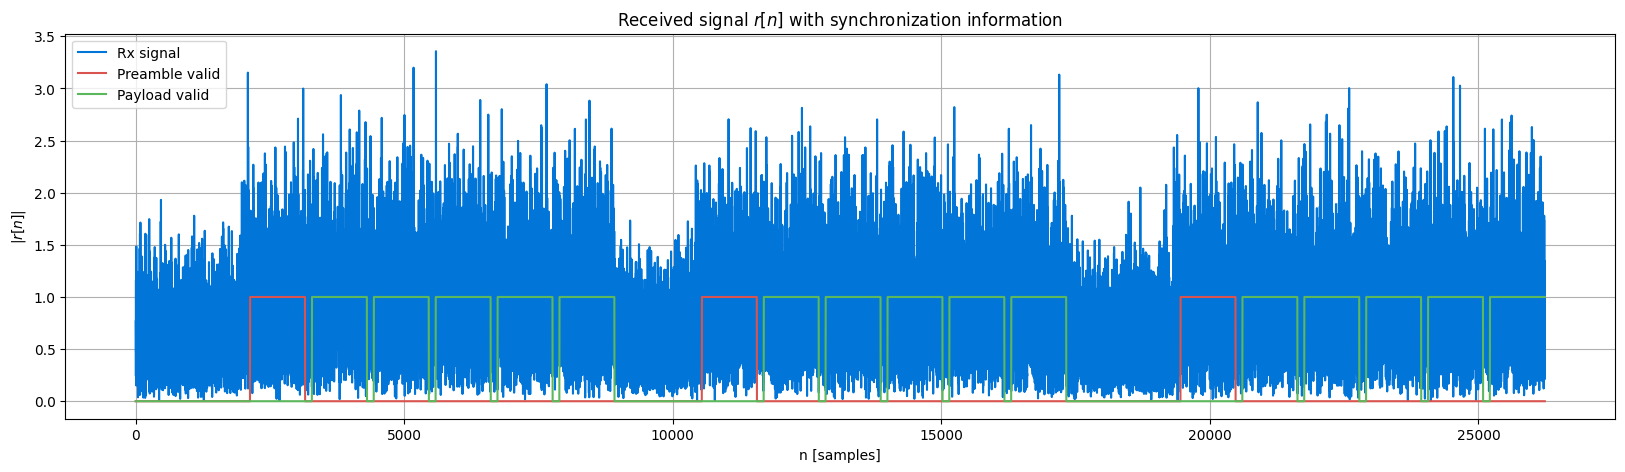

In [25]:
delays = [1000, 1500, 2000]
tx_signal = []
preamble_valid = []
payload_valid = []
for d in delays:
    Z = np.zeros(d)
    frame, pream_valid, pay_valid = createFrame_withSyncInfo(ofdm)
    tx_signal.extend([Z, frame])
    preamble_valid.extend([Z, pream_valid])
    payload_valid.extend([Z, pay_valid])

tx_signal = np.hstack(tx_signal)
preamble_valid = np.hstack(preamble_valid)
payload_valid = np.hstack(payload_valid)

rx_signal = addNoise(addSTO(tx_signal, sto), 0.5)
preamble_valid = addSTO(preamble_valid, sto)
payload_valid = addSTO(payload_valid, sto)

plt.figure(figsize=(20, 5))
plt.title('Received signal $r[n]$ with synchronization information')
plt.plot(np.abs(rx_signal), label='Rx signal')
plt.plot(preamble_valid, label='Preamble valid')
plt.plot(payload_valid, label='Payload valid')
plt.xlabel('n [samples]')
plt.ylabel('$|r[n]|$')
plt.legend()
plt.grid(True)

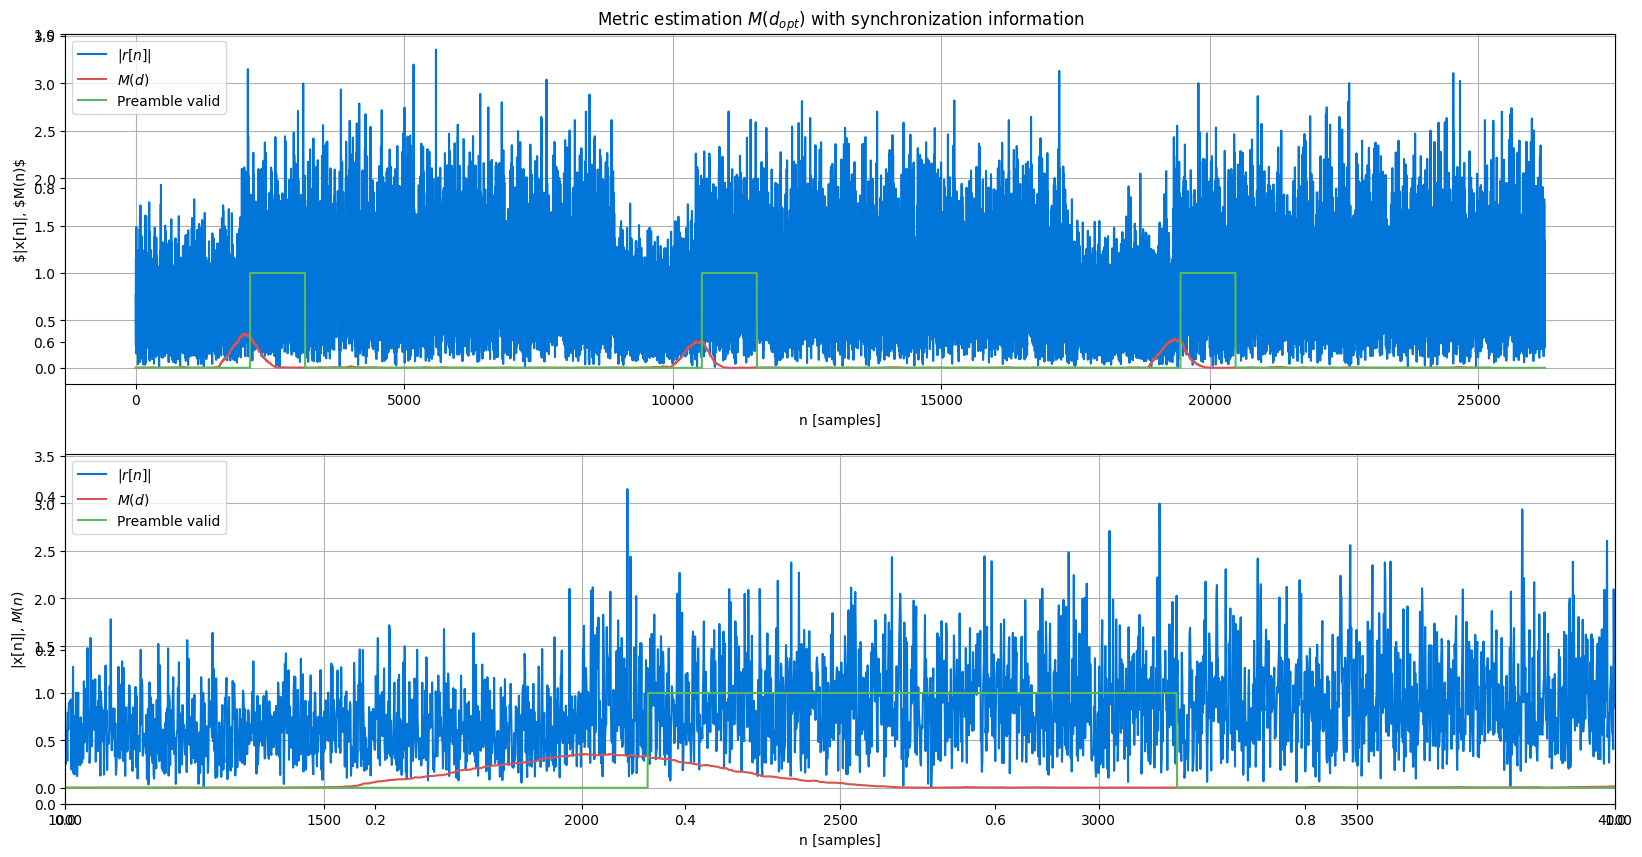

In [26]:
P, R, M = calcP_R_M(rx_signal, ofdm.L)

plt.figure(figsize=(20, 10))
plt.title('Metric estimation $M(d_{opt})$ with synchronization information')

# Plot on the whole range
plt.subplot(2, 1, 1)
plt.plot(abs(rx_signal), label='$|r[n]|$')
plt.plot(abs(M), label='$M(d)$')
plt.plot(preamble_valid, label='Preamble valid')
plt.legend()
plt.xlabel('n [samples]')
plt.ylabel('$|x[n]|, $M(n)$')
plt.grid(True)

# Zoom in to the interesting part
plt.subplot(2, 1, 2)
plt.plot(abs(rx_signal), label='$|r[n]|$')
plt.plot(abs(M), label='$M(d)$')
plt.plot(preamble_valid, label='Preamble valid')
plt.xlim(1000, 4000)
plt.legend()
plt.xlabel('n [samples]')
plt.ylabel('|x[n]|, $M(n)$')
plt.grid(True)



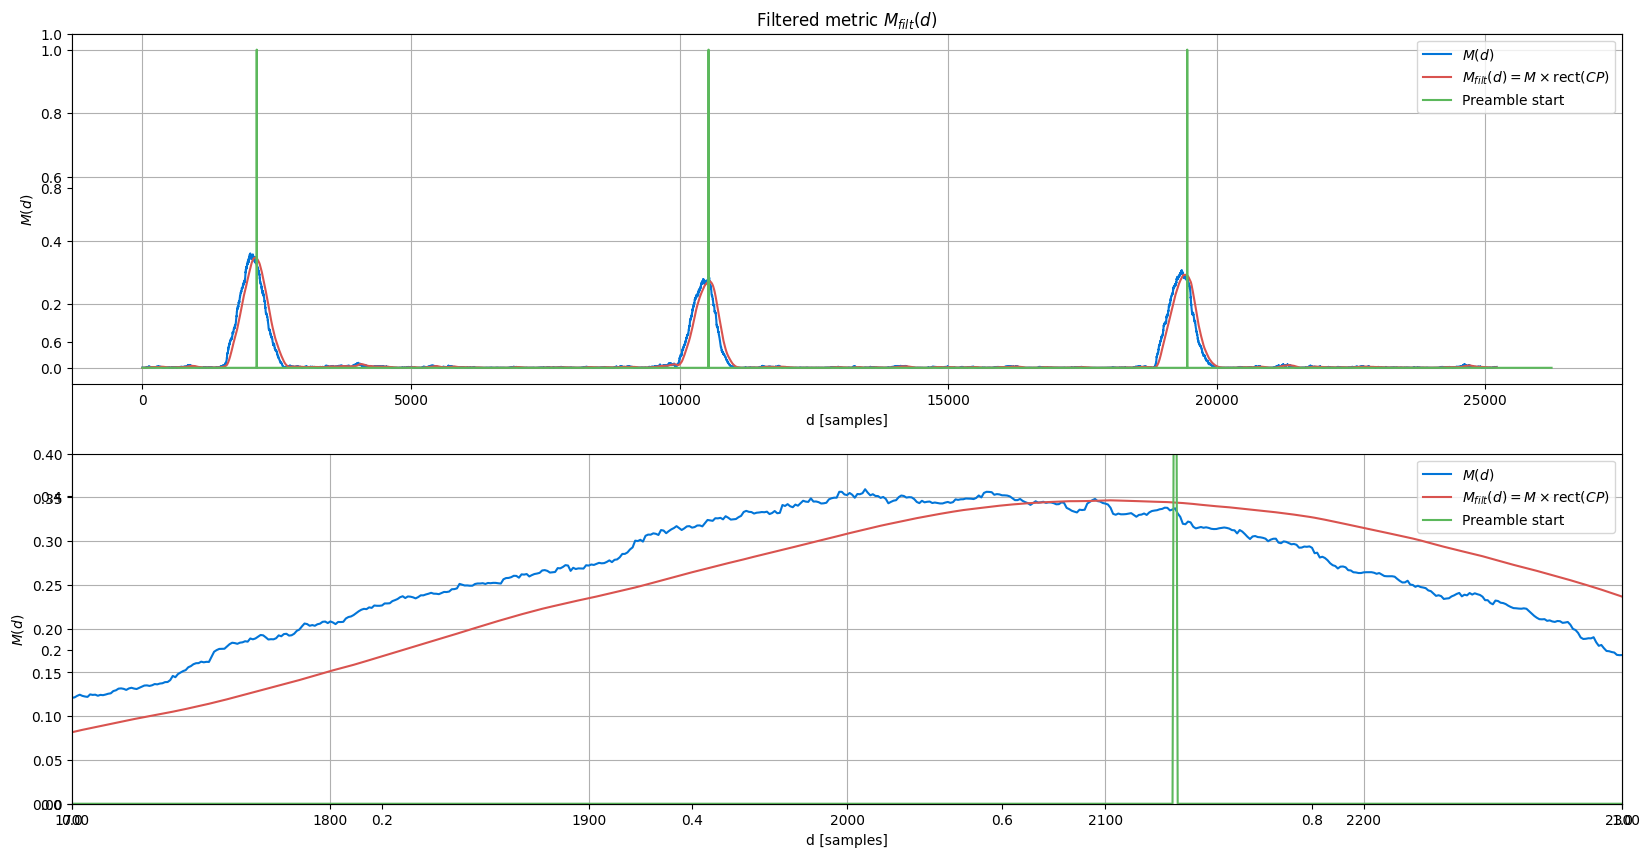

In [27]:
b_toPeak = np.ones(ofdm.CP) / ofdm.CP
a = (1, )
M_filt = sp.signal.lfilter(b_toPeak, a, M)

preamble_start = np.diff(preamble_valid) == 1   # Calculate a flag indicating the start of the preamble

plt.figure(figsize=(20, 10))
plt.title('Filtered metric $M_{filt}(d)$')

plt.subplot(2, 1, 1)
plt.plot(M, label='$M(d)$')
plt.plot(M_filt, label='$M_{filt}(d) = M \\times \\text{rect}(CP)$')
plt.plot(preamble_start, label='Preamble start')
plt.legend()
plt.xlabel('d [samples]')
plt.ylabel('$M(d)$')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(M, label='$M(d)$')
plt.plot(M_filt, label='$M_{filt}(d) = M \\times \\text{rect}(CP)$')
plt.plot(preamble_start, label='Preamble start')
plt.legend()
plt.xlabel('d [samples]')
plt.ylabel('$M(d)$')
plt.xlim(1700, 2300)
plt.ylim(0, 0.4)
plt.grid(True)

(-0.0015, 0.0015)

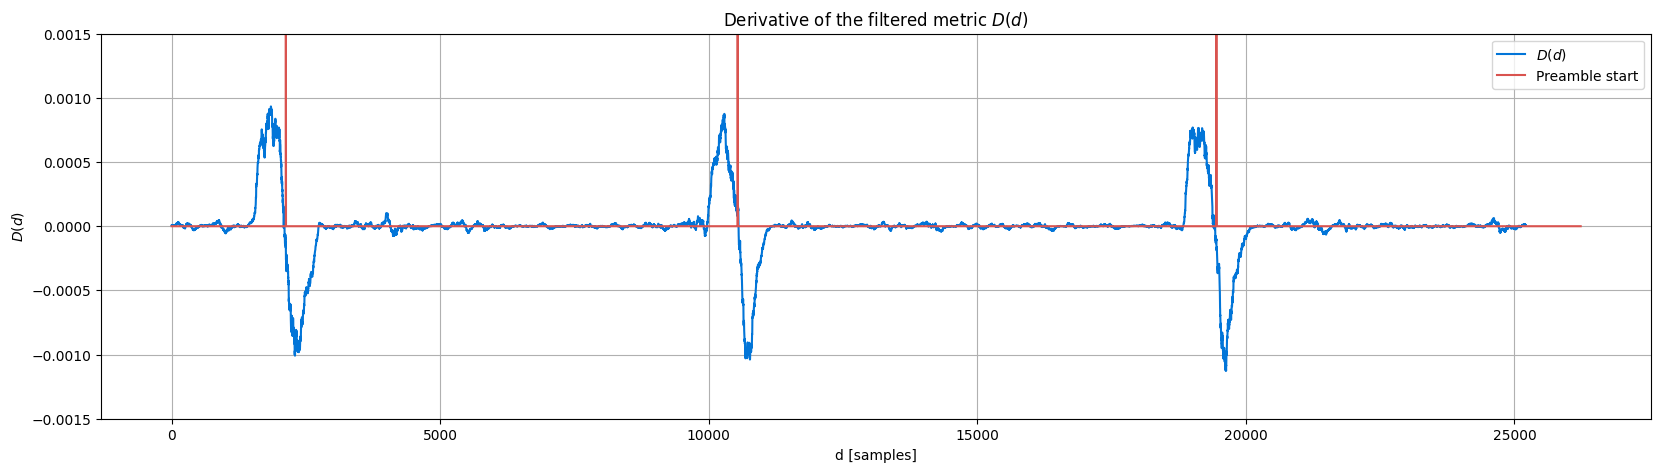

In [28]:
D = np.diff(M_filt)

plt.figure(figsize=(20, 5))
plt.title('Derivative of the filtered metric $D(d)$')
plt.plot(D, label='$D(d)$')
plt.plot(preamble_start, label='Preamble start')
plt.legend()
plt.xlabel('d [samples]')
plt.ylabel('$D(d)$')
plt.grid(True)
plt.ylim(-0.0015, 0.0015)

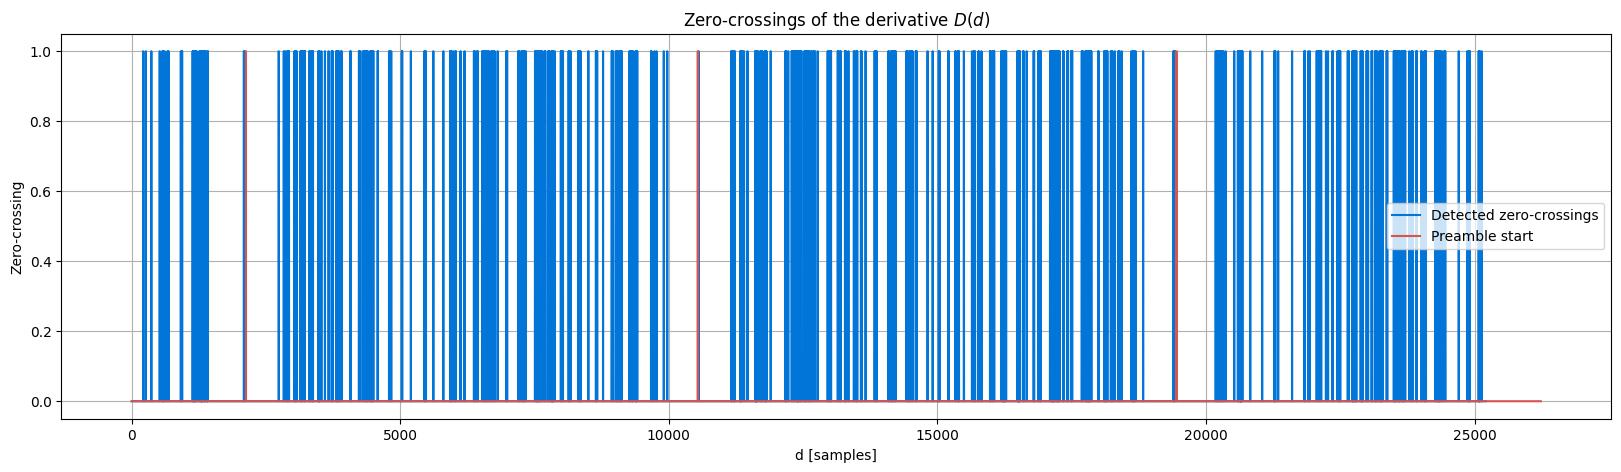

In [29]:
zeroCrossing_1 = (D[:-1] * D[1:]) <= 0

plt.figure(figsize=(20, 5))
plt.title('Zero-crossings of the derivative $D(d)$')
plt.plot(zeroCrossing_1, label='Detected zero-crossings')
plt.plot(preamble_start, label='Preamble start')
plt.legend()
plt.xlabel('d [samples]')
plt.ylabel('Zero-crossing')
plt.grid(True)

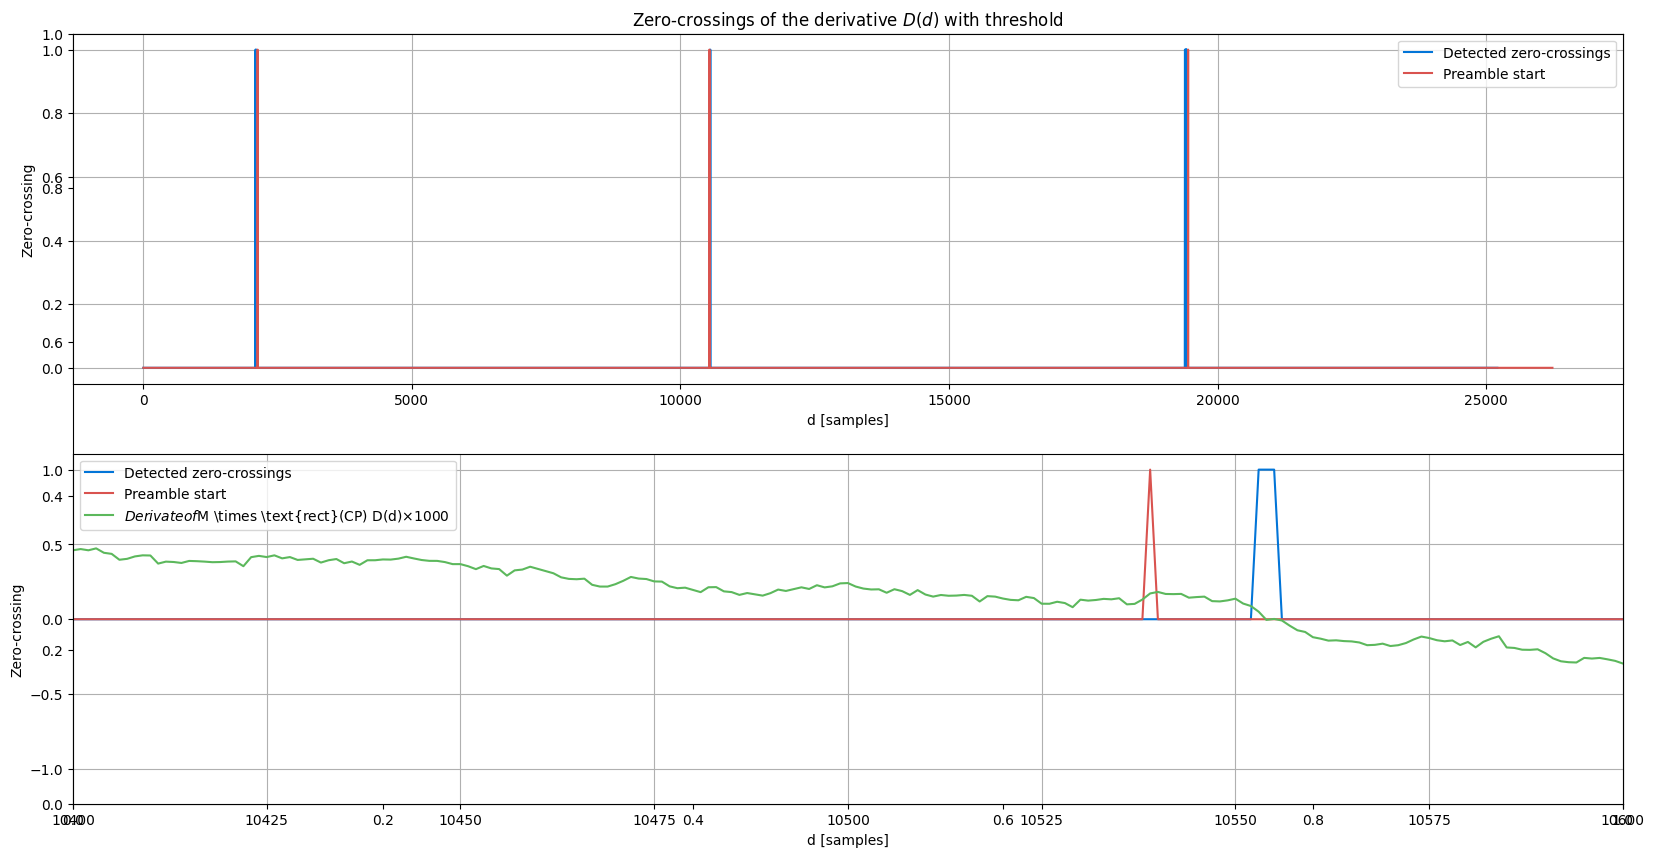

In [30]:
zeroCrossing_2 = ((D[:-1] * D[1:]) <= 0) * (M[1:-1] > 0.1)

plt.figure(figsize=(20, 10))
plt.title('Zero-crossings of the derivative $D(d)$ with threshold')

plt.subplot(2, 1, 1)
plt.plot(zeroCrossing_2, label='Detected zero-crossings')
plt.plot(preamble_start, label='Preamble start')
plt.legend()
plt.xlabel('d [samples]')
plt.ylabel('Zero-crossing')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(zeroCrossing_2, label='Detected zero-crossings')
plt.plot(preamble_start, label='Preamble start')
plt.plot(D * 1000, label='$Derivate of $M \\times \\text{rect}(CP) D(d)$ \\times 1000$')
plt.legend()
plt.xlabel('d [samples]')
plt.ylabel('Zero-crossing')
plt.xlim(10400, 10600)
plt.grid(True)

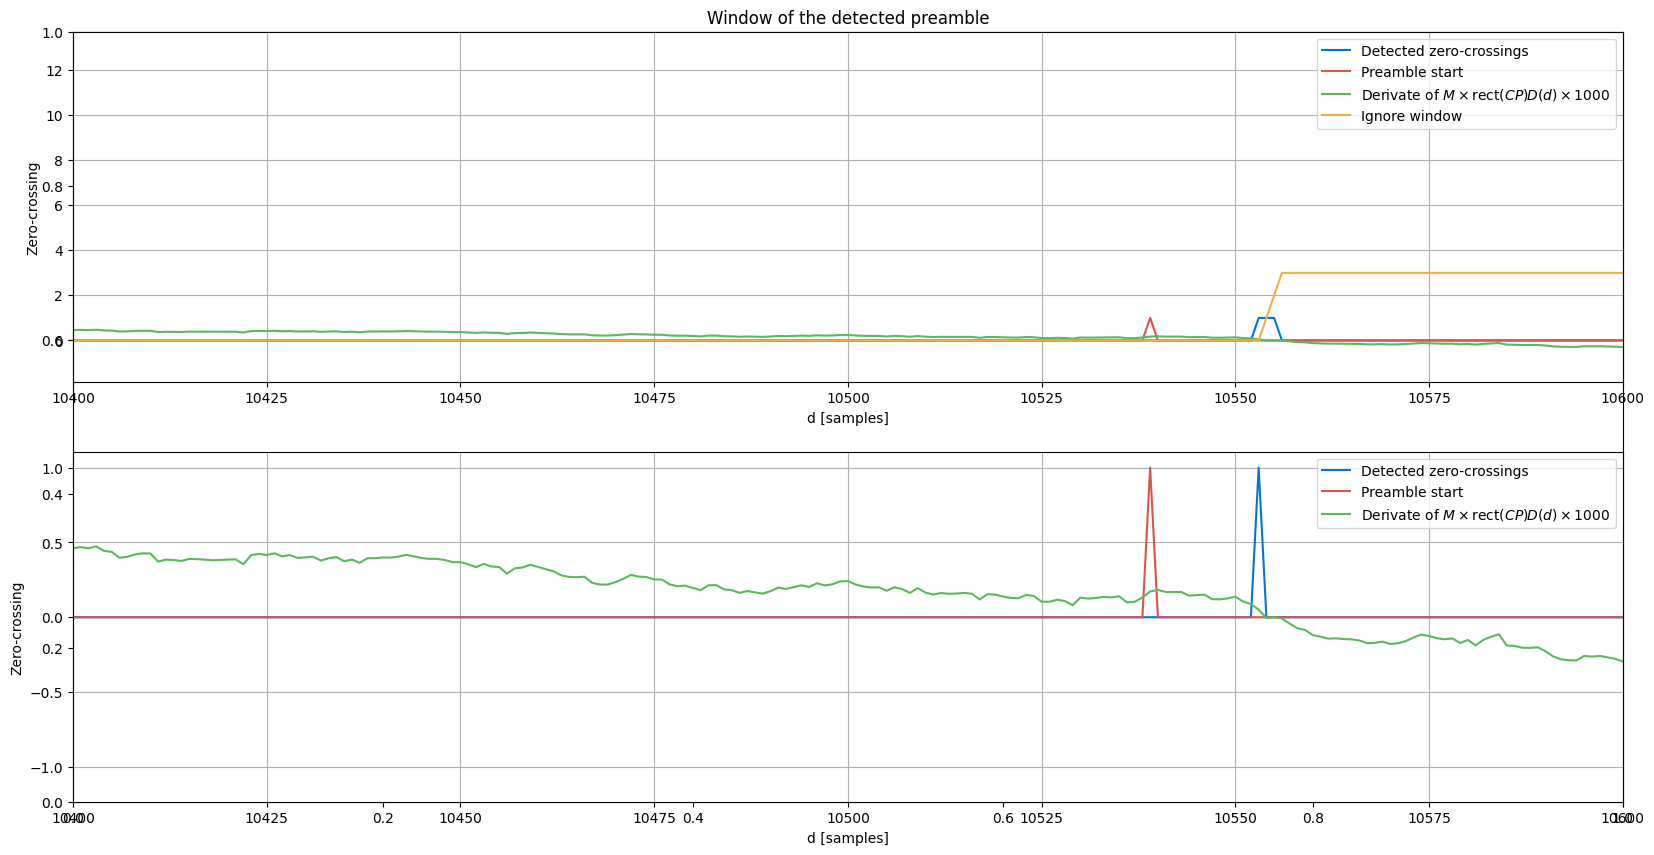

In [31]:
# Create a rectangle window that remains switched on as for the length of the symbol
b_ignore = np.ones(1 + ofdm.K + ofdm.CP)
b_ignore[0] = 0
ignore_times = sp.signal.lfilter(b_ignore, (1, ), zeroCrossing_2 > 0).astype(int)

zeroCrossing_3 = zeroCrossing_2 * (ignore_times == 0) # Keep only the zero-crossings where the ignore-window is not active

plt.figure(figsize=(20, 10))
plt.title('Window of the detected preamble')

plt.subplot(2, 1, 1)
plt.plot(zeroCrossing_2, label='Detected zero-crossings')
plt.plot(preamble_start, label='Preamble start')
plt.plot(D * 1000, label='Derivate of $M \\times \\text{rect}(CP) D(d) \\times 1000$')
plt.plot(ignore_times, label='Ignore window')
plt.legend()
plt.xlabel('d [samples]')
plt.ylabel('Zero-crossing')
plt.xlim(10400, 10600)
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(zeroCrossing_3, label='Detected zero-crossings')
plt.plot(preamble_start, label='Preamble start')
plt.plot(D * 1000, label='Derivate of $M \\times \\text{rect}(CP) D(d) \\times 1000$')
plt.legend()
plt.xlabel('d [samples]')
plt.ylabel('Zero-crossing')
plt.xlim(10400, 10600)
plt.grid(True)

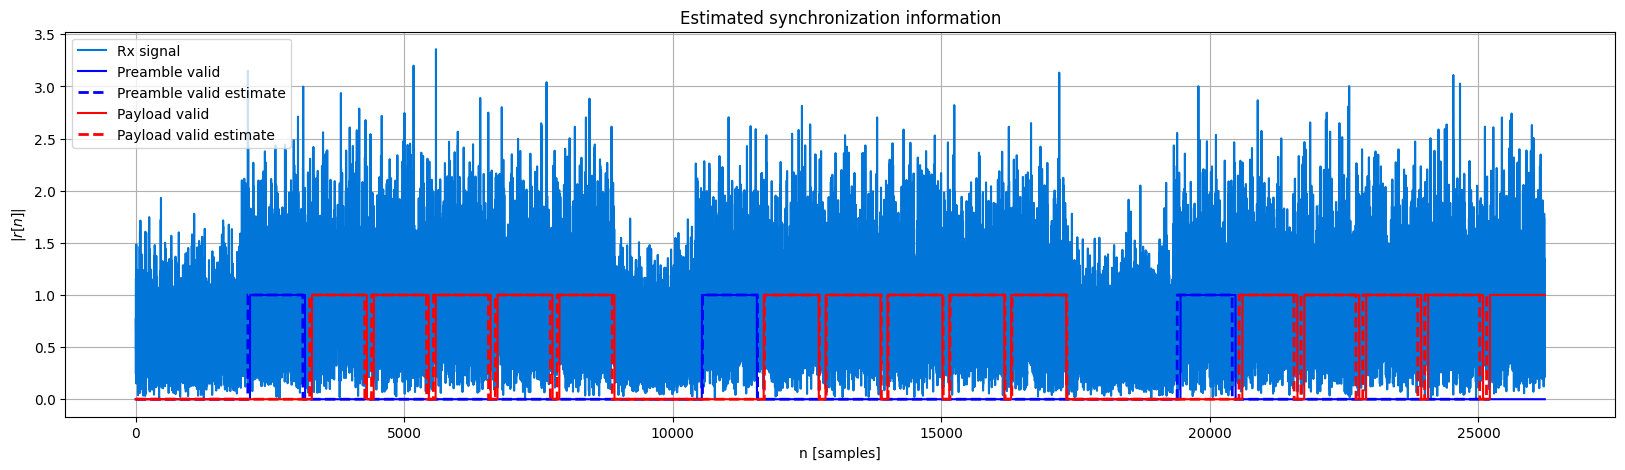

In [32]:
b_preamble = np.zeros(ofdm.K + ofdm.ofdmSymbolsPerFrame * (ofdm.K + ofdm.CP))
b_preamble[:ofdm.K] = 1

b_payload = np.zeros(ofdm.K + ofdm.ofdmSymbolsPerFrame * (ofdm.K + ofdm.CP))
for s in range(ofdm.ofdmSymbolsPerFrame):
    b_payload[ofdm.K + (s + 1) * ofdm.CP + s * ofdm.K + np.arange(ofdm.K)] = 1
    
preamble_valid_est = sp.signal.lfilter(b_preamble, (1, ), zeroCrossing_3)
payload_valid_est = sp.signal.lfilter(b_payload, (1, ), zeroCrossing_3)

plt.figure(figsize=(20, 5))
plt.title('Estimated synchronization information')
plt.plot(abs(rx_signal), label='Rx signal')
plt.plot(preamble_valid, label='Preamble valid', color='blue')
plt.plot(preamble_valid_est, label='Preamble valid estimate', color='blue', linestyle='--', lw=2)
plt.plot(payload_valid, label='Payload valid', color='red')
plt.plot(payload_valid_est, label='Payload valid estimate', color='red', linestyle='--', lw=2)
plt.xlabel('n [samples]')
plt.ylabel('$|r[n]|$')
plt.legend()
plt.grid(True)